In [1]:
import numpy as np
from scipy.linalg import toeplitz
from tt.eigb import *
import tt
import time
from math import pi,sqrt
import quadgauss
import os
import sys

import matplotlib.pyplot as plt
%matplotlib inline

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 27 days


In [2]:
f = 4 #The number of degrees of freedom
L = 7 #The domain is [-L, L], periodic
lm = 0.111803 #The magic constant
#lm = 0 #The magic constant
#lm = 1e-2
#lm = 
N = 15 # The size of the spectral discretization

x, ws = quadgauss.cdgqf(N,6,0,0.5) #Generation of hermite quadrature
#Generate Laplacian
lp = np.zeros((N,N))
for i in xrange(N):
    for j in xrange(N):
        if i is not j:
            lp[i,j] = (-1)**(i - j)*(2*(x[i] - x[j])**(-2) - 0.5)
        else:
            lp[i,j] = 1.0/6*(4*N - 1 - 2 * x[i]**2)
lp = tt.matrix(lp)
e = tt.eye([N])

lp2 = None
eps = 1e-6
for i in xrange(f):
    w = lp
    for j in xrange(i):
        w = tt.kron(e,w)
    for j in xrange(i+1,f):
        w = tt.kron(w,e)
    lp2 = lp2 + w
    lp2 = lp2.round(eps)


#Now we will compute Henon-Heiles stuff
xx = []
t = tt.tensor(x)
ee = tt.ones([N])
for  i in xrange(f):
    t0 = t
    for j in xrange(i):
        t0 = tt.kron(ee,t0)
    for j in xrange(i+1,f):
        t0 = tt.kron(t0,ee)
    xx.append(t0)

#Harmonic potential
harm = None
for i in xrange(f):
    harm = harm + (xx[i]*xx[i])
    harm = harm.round(eps)

#Henon-Heiles correction
V = None
for s in xrange(f-1):
    V = V + (xx[s]*xx[s]*xx[s+1] - (1.0/3)*xx[s+1]*xx[s+1]*xx[s+1])
    V = V.round(eps)
B = 35

lm = 0
A = 0.5*lp2 + tt.diag(0.5*harm + lm*V)
A0 = 0.5*lp2 + tt.diag(0.5*harm)
A = A.round(eps) 

n = A.n
d = A.tt.d
r = [5]*(d+1)
r[0] = 1
r[d] = B
x0 = tt.rand(n,d,r)

t1 = time.time()
print 'Matrices are done'
y,lam = eigb(A,x0,1e-6)
#y,lam = eigb(A0,y,1e-6)
#y,lam = eigb(A,y,1e-6,nswp=1)
#y,lam = eigb(A,y,1e-5)
#y,lam = eigb(A,y,1e-6)
t2 = time.time()
print 'Eigenvalues:',lam    
print 'Elapsed time:', t2-t1

Matrices are done
Eigenvalues: [ 2.  3.  3.  3.  3.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  5.  5.  5.
  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.]
Elapsed time: 6.72520494461


In [3]:
def block_matvec_right(M, vecs, eps, rmax=99999):

    n, m = M.shape
    if len(vecs) <> m:
        raise Exception('Incorrect matrix size')
    
    new_vecs = []
    for i in range(n):
        w = None
        for j in range(m):
            w += M[i, j] * vecs[j]
            w = w.round(eps, rmax=rmax)
        new_vecs.append(w)
        
    return new_vecs


def block_matvec_left(M, vecs, eps, rmax=99999):

    n, m = M.shape
    if len(vecs) <> n:
        raise Exception('Incorrect matrix size')
    
    new_vecs = []
    for j in range(m):
        w = None
        for i in range(n):
            w += vecs[i] * M[i, j]
            w = w.round(eps, rmax=rmax)
        new_vecs.append(w)
        
    return new_vecs


def block_bilin(vecs1, vecs2):
    
    n = len(vecs1)
    m = len(vecs2)
    b = np.zeros((n, m))
    
    for i in range(n):
        for j in range(m):
            b[i, j] = tt.dot(vecs1[i], vecs2[j])
            
    return b


def block_qr(vecs, eps, rmax=99999):
    
    n = len(vecs)
    g = block_bilin(vecs, vecs)
    L = np.linalg.cholesky(g)
    
    vecs_orthog = block_matvec_left(np.linalg.inv(L).T, vecs, eps, rmax=rmax)
    
    return vecs_orthog, L

def eigb_to_list(y):
    y_list = tt.tensor.to_list(y)
    d = y.d
    first_cores = y_list[:-1]
    y_last_core = y_list[-1]
    n, m, B = y_last_core.shape
    
    res = []
    for i in range(B):
        #print i
        #print y_last_core[:, :, i].reshape([n, m, 1], order='f').shape
        first_cores.append(y_last_core[:, :, i].reshape([n, m, 1], order='f'))
        res.append(tt.tensor.from_list(first_cores))
        first_cores = first_cores[:-1]
                   
    return res

In [97]:
5.**12 * 8 / 1000000

1953.125

In [4]:
mlp = lp.full()
l, s = np.linalg.eig(lp.full() + np.diag(x**2))

ee = tt.ones([N])
Lambda = None #tt.tensor(l)
w = tt.tensor(l)
for i in xrange(f):
    t = w.copy()
    for j in xrange(i):
        t = tt.kron(ee, t)
    for j in xrange(i+1, f):
        t = tt.kron(t, ee)
    Lambda += t
    Lambda = Lambda.round(eps)
t = tt.matrix(s)
S = t.copy()
for i in xrange(f-1):
    S = tt.kron(S, t)

In [5]:
#E = -0.3#9.97282311
pot = 0.5 * harm
lm = 0.111803
A0 = (0.5*lp2 + tt.diag(pot) + lm*tt.diag(V)).round(eps)
A_harm = (0.5*lp2 + tt.diag(pot)).round(eps)
y, lam = eigb(A0, y, eps)
y_harm, lam_harm = eigb(A_harm, x0, eps)
y_full = eigb_to_list(y)

In [87]:
from tt.amen import amen_solve

#def initial_guess(d, y0=None):
#    if y0 == None:
        

def amen_inverse_iter(psi0, E0, A, eps, shift=None, niter=50, rmax=10, 
                          nswp=2, kickrank=2, verb=1, verb_amen=0):
    
    if shift is None:
        shift = np.zeros(len(E0))
        
        
    Logger = {}
    Logger['err_en'] = []
    Logger['err_psi'] = []
    
    B = len(E0)
    n = psi0[0].n
    
    psi = copy.deepcopy(psi0)
    E_new = copy.deepcopy(E0)
    
    
    for i in range(niter):
        
        # Step 1: Calculate psi_new = (A - shift * I)**(-1) psi
        psi_new = []
        #shift = E_new
        for j in range(B):
            A_shifted = A - shift[j] * tt.diag(tt.ones(n))
            psi_new_j = amen_solve(A_shifted, psi[j], psi[j], eps, nswp=nswp).round(eps, rmax=rmax)
            sc = tt.dot(psi_new_j, tt.ones(psi_new_j.n))
            sc = sc / np.abs(sc)
            psi_new.append(sc* psi_new_j)
        
        # Step 2: Orthogonalize psi_new
        #for i in range(B):
        #    psi_new[i] = (1.0/psi_new[i].norm()) * psi_new[i]
        psi_new, L = block_qr(psi_new, eps, rmax=rmax)
        
        # Step 3: Calculate F = psi_new^T A psi_new
        Apsi_new = []
        for j in range(B):
            Apsi_new.append(tt.matvec(A, psi_new[j]))
        F = block_bilin(psi_new, Apsi_new)
         
        # Step 4: Diagonalize F:
        E_new, S = np.linalg.eigh(F)
        
        # Step 5: Set psi = S psi_new
        psi = block_matvec_left(S, psi_new, eps, rmax=rmax)
        
        print E_new

        
    return E_new, psi


def harm_prec(y, E, eps, S, Lambda, shift, **kwargs):
    y = tt.matvec(S.T, y)
    y = tt.multifuncrs2([y, Lambda], lambda x: x[:, 0]/(0.5*x[:, 1] - shift[j]), eps, **kwargs)
    y = tt.matvec(S, y)
    return y.round(eps)


def eig_steepest_descent(A, en0, x0, 
                       eps=1e-5, maxiter=50, 
                       V_anharm=None, shift=None, P=None,
                       rmax=10, nswp=2, kickrank=2, 
                       verb=1, verb_solvers=0, 
                       E_exact=None):
    '''
    
    Input:
        
        A: TT matrix representation of (-Laplace + V_harm + V_anharm)        
        E0: initial guess for energies
        PSI0: initial guess for eigenfunctions
        METHOD: method for solving the problem. Can be
            'inverse_iter': x_new = (A - shift)^{-1} x
            'prec_descent': preconditioned steepest descent: x_new = x - tau_opt * P * (Ax - Ex)
            'power_iter': not implemented
            'descent': not implemented           
        EPS: accuracy of operations in the TT format      
        MAXITER: maximum number of global iterations        
        V_ANHARM: anharmonic part of the operator. Required for the 'prec_descent' method       
        SHIFT: shift of operators that are inverted during the iteration. If shift=None, then no shift is done
        P: preconditioner, P = P(x, E), where x is a TT tensor, E is current array of eigenvalues
        RMAX: truncation rank parameter. After each operation tensors are truncated with this parameter       
        NSWP, KICKRANK: internal parameters of multifuncrs/amen_solve functions       
        VERB: if verb=1, accuracy of energy will be printed on each step        
        VERB_SOLVERS: if verb_solvers=1, internal solver (multifun/amen_solver) iterations will be printed on each step        
        E_EXACT: exact eigenvalues of A. If given, then logger will contain additional information about convergence with respect to E_exact 
   
    Output:
        
        E: 1D numpy array of calculated eigenvalues    
        PSI: list of TT tensors (calculated eigenfunctions)    
        LOGGER: dictionary with internal information about the iteration process. Keys:
            'err_en': list of |E_{k+1} - E_{k}| / |E_{k+1}|, where k is the iteration number
            'err_en_exact': list of |E_{k} - E_exact| / |E_exact| if E_exact is not None
            'err_psi': list of ||psi_{k+1} - psi_{k}|| / ||psi_{k+1}||
            'en': list of E_{k}
            'F': list of Fock matrices: psi_k^T A psi_k
    '''
    
    if P == None:
        def P(x, E, **kwargs): return x # Identity operator
    
    if shift is None:
        shift = np.zeros(len(E0))
        
    if method == 'prec_descent' and V == None:
        raise Exception('Anharmonic part of the potential is required (parameter V)')
              
    logger = {}
    logger['err_en'] = []
    logger['err_en_exact'] = []
    logger['err_psi'] = []
    logger['en'] = []
    logger['F'] = []
    
    B = len(E0)
    n = psi0[0].n
    
    psi = copy.deepcopy(psi0)
    E = copy.deepcopy(E0)   
    
    for i in range(maxiter):
        
        # Step 1: Calculate psi_new = psi - tau_opt * (A_harm - shift)^{-1}(Ax - Ex), where A = A_harm + V
        #shift = E - 1e-1
        psi_new = []
        for j in range(B):
            sc = tt.dot(psi[j], tt.ones(psi[j].n)) # sc is -1 or +1. Was introduced to measure err_psi.
            sc = sc / np.abs(sc)
            psi[j] = sc * psi[j]
            
            Apsi_j = tt.matvec(A, psi[j])
            r = (tt.matvec(A, psi[j]) - E[j]*psi[j]).round(eps)
            r = P(r, E, rmax=rmax, kickrank=kickrank, nswp=nswp, verb=0)
            tau = optimal_step(A, psi[j], r, eps)
            psi_new.append((psi[j] - tau * r).round(eps, rmax=rmax))
    
        # Step 2: Orthogonalize psi_new
        psi_new, L = block_qr(psi_new, eps, rmax=rmax)
        
        # Step 3: Calculate F = psi_new^T A psi_new
        Apsi_new = []
        for j in range(B):
            Apsi_new.append(tt.matvec(A, psi_new[j]))
        F = block_bilin(psi_new, Apsi_new)

        # Step 4: Diagonalize F:
        E_new, U = np.linalg.eigh(F)

        # Step 5: Set psi = S psi_new
        psi_new = block_matvec_left(U, psi_new, eps, rmax=rmax)
        
        # Log step:
        err_en = np.abs((E - E_new) / E_new)
        err_psi = [(psi[j] - psi_new[j]).norm() / (psi_new[j]).norm() for j in range(B)]
        err_psi = np.array(err_psi)
        if E_exact is not None: 
            err_en_exact = np.abs((E - E_exact) / E_exact)
        else:
            err_en_exact = None
        
        logger['err_en'].append(err_en)
        logger['err_en_exact'].append(err_en_exact)
        logger['err_psi'].append(err_psi)
        logger['en'].append(E_new)
        logger['F'].append(F)
        
        if verb == 1:
            print 'Iteration', i+1, ', err_best_orb =', np.min(err_en), ', err_worst_orb =', np.max(err_en)
        
        psi = copy.deepcopy(psi_new)
        E = copy.deepcopy(E_new)
               
    return E, psi, logger


def optimal_step(A, x, r, eps):
    Ax = tt.matvec(A, x).round(eps)
    Ar = tt.matvec(A, r).round(eps)
    
    a1 = tt.dot(Ax, x)
    a2 = -2.0 * tt.dot(Ar, x)
    a3 = tt.dot(Ar, r)
    
    b1 = tt.dot(x, x)
    b2 = -2.0 * tt.dot(r, x)
    b3 = tt.dot(r, r)
    
    p = [a3*b2 - a2*b3, 2*(a3*b1 - a1*b3), a2*b1 - a1*b2]
    roots = np.roots(p)
    
    f = (a1 + a2*roots + a3*roots**2) / (b1 + b2*roots + b3*roots**2)
    return roots[np.argmin(f)]

In [83]:
import copy
eps = 1e-6
#psi = tt.ones(N, d)

psi0 = []
for i in range(B):
    psi0.append(tt.rand(N, d))
psi0, _ = block_qr(psi0, eps)
#psi0 = eigb_to_list(y_harm)
E0 = lam_harm #10.3
rmax = 15
nswp = 4
kickrank = 2

maxiter = 20

P = lambda y, E, **kwargs: harm_prec(y, E, eps, S, Lambda, E0-0.1, **kwargs)

E, psi, logger_prec = vibrational_solver(A0, E0, psi0, 
                                        method='inverse_iter', eps=eps, maxiter=maxiter, 
                                        V_anharm=lm*V, shift=E0-0.1, P=P,
                                        rmax=rmax, nswp=nswp, kickrank=kickrank, 
                                        verb=1, verb_solvers=0, 
                                        E_exact=lam)

Iteration 1 , err_best_orb = 0.43546546444 , err_worst_orb = 0.824507969503
Iteration 2 , err_best_orb = 0.761596361078 , err_worst_orb = 4.1800436326
Iteration 3 , err_best_orb = 0.00286375684523 , err_worst_orb = 0.939896177305
Iteration 4 , err_best_orb = 0.000130721746727 , err_worst_orb = 0.239376506911
Iteration 5 , err_best_orb = 2.0780005893e-05 , err_worst_orb = 0.098337586423
Iteration 6 , err_best_orb = 5.67130949293e-06 , err_worst_orb = 0.0650218038791
Iteration 7 , err_best_orb = 4.92432794744e-07 , err_worst_orb = 0.0447805554665
Iteration 8 , err_best_orb = 1.9734275523e-07 , err_worst_orb = 0.0281094763728
Iteration 9 , err_best_orb = 3.24902740034e-08 , err_worst_orb = 0.0381944286051
Iteration 10 , err_best_orb = 7.76507919169e-09 , err_worst_orb = 0.0547399030861
Iteration 11 , err_best_orb = 4.01456651755e-09 , err_worst_orb = 0.0327993638678
Iteration 12 , err_best_orb = 1.23158996257e-09 , err_worst_orb = 0.0206563877678
Iteration 13 , err_best_orb = 4.0943560046

In [141]:
import copy
eps = 1e-6
psi = tt.ones(N, d)

psi0 = []
for i in range(B):
    psi0.append(tt.rand(N, d))
psi0, _ = block_qr(psi0, eps)
psi0 = eigb_to_list(y_harm)
E0 = lam_harm #10.3
rmax = 15
nswp = 5
kickrank = 2

niter = 25

E, psi = amen_inverse_iter(psi0, E0, A0, eps, shift=E0, niter=niter, rmax=rmax, 
                          nswp=nswp, kickrank=2, verb=1, verb_amen=0)

for i in range(B):
    print (tt.matvec(A0, psi[i]) - E[i]*psi[i]).norm()/E[i]
    
for i in range(B):
    print (tt.matvec(A0, y_full[i]) - lam[i]*y_full[i]).norm()/lam[i]
    
for i in range(B):
    print (tt.matvec(A_harm, psi0[i]) - lam_harm[i]*psi0[i]).norm()/lam_harm[i]

[ 1.99572534  2.97260248  2.98099075  2.98718138  2.98925455  3.90399329
  3.9314713   3.96209672  3.96270887  3.97126001  3.97501182  3.97708365
  3.98225655  3.98265821  3.98613973  4.95282752  4.95930386  4.96799212
  4.97704249  4.98303371]
[ 1.99572534  2.9726017   2.98099045  2.98718125  2.98925447  3.90295611
  3.93102619  3.9620505   3.96267102  3.9712428   3.97499441  3.97707431
  3.9822534   3.98265447  3.98613852  4.96020767  4.97135279  4.97539221
  4.98046576  4.98492393]


KeyboardInterrupt: 

In [27]:
import copy
eps = 1e-6
#psi = tt.ones(N, d)

psi0 = []
for i in range(B):
    psi0.append(tt.rand(N, d))
psi0, _ = block_qr(psi0, eps)
#psi0 = eigb_to_list(y_harm)
E0 = lam_harm #10.3
rmax = 15
nswp = 5
kickrank = 2

niter = 20

E, psi, logger_prec = prec_inverse_iter(E0, psi0, A0, eps, shift=E0-0.1, niter=niter, rmax=rmax, 
                          nswp=nswp, kickrank=kickrank, verb=1, verb_multifun=0, lm=0.111803)

print 'Hi'
for i in range(B):
    print (tt.matvec(A0, psi[i]) - E[i]*psi[i]).norm()/E[i]
    
for i in range(B):
    print (tt.matvec(A0, y_full[i]) - lam[i]*y_full[i]).norm()/lam[i]
    
for i in range(B):
    print (tt.matvec(A_harm, psi0[i]) - lam_harm[i]*psi0[i]).norm()/lam_harm[i]

Iteration 1 err best orb = 0.79942330442 err worst orb = 0.877658706284
Iteration 2 err best orb = 1.07139256667 err worst orb = 3.86443298514
Iteration 3 err best orb = 0.0170770384503 err worst orb = 0.959277927507
Iteration 4 err best orb = 0.00517419079341 err worst orb = 0.267709250015
Iteration 5 err best orb = 0.000314483557027 err worst orb = 0.295460492168
Iteration 6 err best orb = 1.30820723569e-05 err worst orb = 0.133000467899
Iteration 7 err best orb = 1.65351820072e-06 err worst orb = 0.00526412356052
Iteration 8 err best orb = 2.66672787591e-07 err worst orb = 0.00140900350995
Iteration 9 err best orb = 5.24113716868e-08 err worst orb = 0.000602739327762
Iteration 10 err best orb = 1.17402868669e-08 err worst orb = 0.000307974781056
Iteration 11 err best orb = 3.1013446356e-09 err worst orb = 0.000171885800809
Iteration 12 err best orb = 8.29756479502e-10 err worst orb = 0.000113538988093
Iteration 13 err best orb = 2.29141737963e-10 err worst orb = 6.11214045216e-05
It

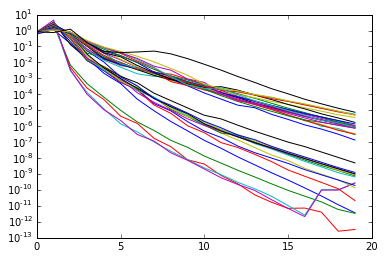

In [72]:
plt.semilogy(logger_prec['err_en'])

In [29]:
psi

[This is a 20-dimensional tensor 
 r(0)=1, n(0)=15 
 r(1)=5, n(1)=15 
 r(2)=8, n(2)=15 
 r(3)=8, n(3)=15 
 r(4)=8, n(4)=15 
 r(5)=8, n(5)=15 
 r(6)=8, n(6)=15 
 r(7)=8, n(7)=15 
 r(8)=8, n(8)=15 
 r(9)=7, n(9)=15 
 r(10)=8, n(10)=15 
 r(11)=8, n(11)=15 
 r(12)=8, n(12)=15 
 r(13)=9, n(13)=15 
 r(14)=9, n(14)=15 
 r(15)=8, n(15)=15 
 r(16)=8, n(16)=15 
 r(17)=7, n(17)=15 
 r(18)=8, n(18)=15 
 r(19)=5, n(19)=15 
 r(20)=1 , This is a 20-dimensional tensor 
 r(0)=1, n(0)=15 
 r(1)=9, n(1)=15 
 r(2)=15, n(2)=15 
 r(3)=15, n(3)=15 
 r(4)=15, n(4)=15 
 r(5)=15, n(5)=15 
 r(6)=15, n(6)=15 
 r(7)=15, n(7)=15 
 r(8)=15, n(8)=15 
 r(9)=15, n(9)=15 
 r(10)=15, n(10)=15 
 r(11)=15, n(11)=15 
 r(12)=15, n(12)=15 
 r(13)=15, n(13)=15 
 r(14)=15, n(14)=15 
 r(15)=15, n(15)=15 
 r(16)=15, n(16)=15 
 r(17)=15, n(17)=15 
 r(18)=15, n(18)=15 
 r(19)=8, n(19)=15 
 r(20)=1 , This is a 20-dimensional tensor 
 r(0)=1, n(0)=15 
 r(1)=10, n(1)=15 
 r(2)=15, n(2)=15 
 r(3)=15, n(3)=15 
 r(4)=15, n(4)=15 
 r(5)=1

In [22]:
psi[-1].round(1e-5)

This is a 20-dimensional tensor 
r(0)=1, n(0)=15 
r(1)=5, n(1)=15 
r(2)=12, n(2)=15 
r(3)=14, n(3)=15 
r(4)=15, n(4)=15 
r(5)=15, n(5)=15 
r(6)=15, n(6)=15 
r(7)=15, n(7)=15 
r(8)=15, n(8)=15 
r(9)=15, n(9)=15 
r(10)=15, n(10)=15 
r(11)=15, n(11)=15 
r(12)=15, n(12)=15 
r(13)=15, n(13)=15 
r(14)=15, n(14)=15 
r(15)=15, n(15)=15 
r(16)=15, n(16)=15 
r(17)=15, n(17)=15 
r(18)=14, n(18)=15 
r(19)=6, n(19)=15 
r(20)=1 

In [86]:
E0

array([ 2.,  3.,  3.,  3.,  3.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.])

In [93]:
rmax = 30
E, psi = amen_inverse_iter(psi0, E0, A0, eps, shift=E0, niter=11, rmax=rmax, 
                          nswp=1, kickrank=2, verb=1, verb_amen=0)

for i in range(B):
    print (tt.matvec(A0, psi[i]) - E[i]*psi[i]).norm()/E[i]
    
for i in range(B):
    print (tt.matvec(A0, y_full[i]) - lam[i]*y_full[i]).norm()/lam[i]
    
for i in range(B):
    print (tt.matvec(A_harm, psi0[i]) - lam_harm[i]*psi0[i]).norm()/lam_harm[i]

[  4.16033703   4.33575341   5.29937038   5.7421069    5.98556405
   6.0157627    6.44980268   6.5297815    7.97677523   8.38800511
  10.07346328  10.45468213  10.84732041  11.21445672  11.91663202
  13.39049084  13.57109178  14.89039436  15.04645058  15.44189821
  16.03533762  17.01750343  17.49137012  18.24265795  19.11680181
  19.73811558  21.51163288  21.95154924  22.24824327  22.31618982
  22.43178984  22.66335466  22.94945315  24.11610151  25.18473896]
[ 1.99573435  2.97664064  2.98364271  2.98982897  3.93907184  3.95064966
  3.97680066  3.97801452  3.98358712  3.98886712  4.01590947  4.08788576
  4.22443554  4.75964415  4.9158176   4.96167994  4.96943448  4.99136595
  5.00543856  5.01542754  5.0355529   5.09055092  5.1068002   5.16442701
  5.17670191  5.29434916  5.41462344  5.52229984  5.69978126  5.82254407
  5.96062     6.29483908  7.10624387  7.59512938  7.88386186]
[ 1.99572534  2.97964786  2.98364959  2.98875387  3.52736392  3.93208979
  3.96357206  3.96822173  3.97282517 

In [89]:
lam

array([ 1.99572534,  2.9726017 ,  2.98099045,  2.98718125,  2.98925447,
        3.90295609,  3.93102619,  3.9620505 ,  3.96267085,  3.9712428 ,
        3.97499438,  3.97707431,  3.9822534 ,  3.98265447,  3.98613852,
        4.79760823,  4.82360988,  4.89732035,  4.89988036,  4.9170998 ,
        4.92148678,  4.92619033,  4.93446864,  4.95116642,  4.95137282,
        4.95979281,  4.96171883,  4.96573138,  4.96820398,  4.97475197,
        4.9751176 ,  4.97889208,  4.980359  ,  4.98039516,  4.98517477])

In [90]:
E

array([ 1.99572534,  2.9726017 ,  2.98099045,  2.98718125,  2.98925447,
        3.9029561 ,  3.93102621,  3.9620505 ,  3.96267085,  3.9712428 ,
        3.97499438,  3.97707431,  3.9822534 ,  3.98265447,  3.98613852,
        4.80030835,  4.86188251,  4.8973257 ,  4.90117565,  4.91711662,
        4.92163844,  4.92622472,  4.93453661,  4.95118724,  4.95137418,
        4.95979306,  4.9617207 ,  4.96574206,  4.96820464,  4.97475208,
        4.97511806,  4.97889225,  4.98035908,  4.98039588,  4.98517477])

In [91]:
E0

array([ 2.,  3.,  3.,  3.,  3.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.])

In [94]:
lam-E

array([ -2.12629914e-12,  -5.53779245e-12,  -8.65529870e-12,
        -4.45110615e-12,  -6.13553652e-12,  -2.71072054e-12,
        -1.42197365e-12,   1.27139188e-10,   7.39985850e-12,
        -9.74273995e-11,   1.38089984e-10,  -1.45898404e-10,
         1.21561428e-10,  -1.62222680e-10,  -1.68718373e-11,
        -2.73757284e-09,  -2.48352450e-11,   1.48325796e-13,
         2.22488694e-12,  -7.50510765e-13,  -3.57047725e-13,
        -1.07913678e-12,   4.52970994e-13,   7.94919686e-13,
        -1.21946897e-12,  -1.29851685e-12,  -1.41930911e-12,
        -4.42490489e-12,  -1.79678494e-12,   5.84421400e-13,
         1.95754524e-12,   1.04183329e-12,   6.10178574e-13,
        -3.66728869e-12,  -3.62021524e-12])

In [744]:
block_bilin(psi, psi)

array([[  1.00000000e+00,   1.72822316e-13,   1.66182759e-13,
         -2.61895757e-11,  -9.73796168e-14,  -2.96195933e-09,
         -2.36105383e-09,  -2.06164588e-08,  -1.35446309e-09,
          3.73354429e-09],
       [  1.72772645e-13,   1.00000000e+00,  -8.96793757e-16,
          1.88015517e-09,  -2.10333588e-15,   1.22709727e-09,
         -5.10092238e-09,   1.45882945e-08,  -3.49226111e-08,
          9.73100330e-09],
       [  1.66052949e-13,  -4.56531948e-16,   1.00000000e+00,
          1.86558120e-10,  -2.69155406e-15,   8.57079997e-09,
         -5.15460442e-09,   1.53192565e-09,  -1.13156028e-08,
          9.05383240e-10],
       [ -2.61895757e-11,   1.88015517e-09,   1.86558120e-10,
          1.00000000e+00,  -9.08274657e-10,  -3.89734185e-12,
         -4.46728684e-09,   5.31902589e-08,  -4.25702644e-08,
         -3.11050578e-08],
       [ -9.74621561e-14,  -2.07552459e-15,  -2.58623790e-15,
         -9.08274657e-10,   1.00000000e+00,   1.92967249e-08,
         -6.62101651e-10

In [111]:
%load_ext line_profiler
%lprun -f prec_inverse_iter prec_inverse_iter(psi0, E0, A0, eps, shift=E0-0.1, niter=10, rmax=10, nswp=2, kickrank=1, verb=1, verb_multifun=0, lm=0.111803)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
0.722735942504
0.801329775658
0.188909862586
1.11148925395
0.0395143013146
0.00785903290548
0.0018386768062
0.000520569103356
0.000183263445023
8.07131462729e-05


In [452]:
E

array([ 5.97315457,  5.97583564,  5.97772917,  5.97857276,  5.98073333])

In [148]:
lam_harm

array([ 2.,  3.,  3.,  3.,  3.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  5.,  5.,  5.,  5.,  5.])

In [457]:
%load_ext line_profiler

In [453]:
lam

array([ 4.98711684,  5.96087416,  5.96222979,  5.96436728,  5.96709567])

In [454]:
E0

array([ 5.,  6.,  6.,  6.,  6.])

In [338]:
a = np.random.random((3, 3))
a = a.T.dot(a)
l, s = np.linalg.eigh(a)
print a - s.dot(np.diag(l).dot(s.T))

[[ -8.88178420e-16  -2.44249065e-15  -6.66133815e-16]
 [ -2.44249065e-15  -4.21884749e-15  -1.33226763e-15]
 [ -7.77156117e-16  -1.33226763e-15  -3.33066907e-16]]


In [339]:
print s - s.T

[[ 0.         -0.88591265 -0.82337883]
 [ 0.88591265  0.         -1.59066139]
 [ 0.82337883  1.59066139  0.        ]]


In [340]:
a.T.dot(a)

array([[ 9.79913645,  8.10634151,  3.00644255],
       [ 8.10634151,  6.70611623,  2.48594146],
       [ 3.00644255,  2.48594146,  0.93419937]])

In [342]:
np.linalg.inv(s) - s.T

array([[  3.33066907e-16,  -9.99200722e-16,  -1.24900090e-16],
       [ -2.77555756e-17,  -8.32667268e-17,   2.22044605e-16],
       [  5.55111512e-16,   9.99200722e-16,   3.33066907e-16]])